# Preparations

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cot.models.transformer import Transformer, TransformerConfig
import seaborn as sns
from typing import List
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import trange
from copy import deepcopy
import math
from sympy import fibonacci
import pandas as pd
import torch.nn.functional as F


## Hyper-params

In [2]:
import sys

sys.set_int_max_str_digits(100000)

In [45]:
epochs = 10
batch_size = 64
min_len = 4
max_len = 10
total_runs = 10
SEQ_LEN=16
SAMPLES_SIZE=8192
PAD_ID = 11

config = TransformerConfig(
    vocab_size=12,
    emb_dim=128,
    n_head=1,
    seq_len=SEQ_LEN,
    n_layer=2,
    norm="layer",
    norm_bias=True,
    weight_tying=True,
)


## Datasets

In [4]:
class BaseDigitDataset(Dataset):
    def __init__(self, generator_fn, inversion=False):
        self.inversion=inversion
        self.samples = []
        for _ in range(SAMPLES_SIZE):
            x, y = generator_fn() 
            enc_x, enc_y = self.__encode__(x, y)
            self.samples.append((enc_x, enc_y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        if self.inversion:
            return y, x
        return x, y

    def __encode__(self, x, y):
        enc_x = BaseDigitDataset.pad(self.encode_x(x))
        enc_y = BaseDigitDataset.pad(self.encode_y(y))
        return enc_x, enc_y
    
    def encode_x(self, x):
        digits = [int(d) for d in str(x)]
        return torch.tensor(digits, dtype=torch.long)
    
    def encode_y(self, y):
        digits = [int(d) for d in str(y)]
        return torch.tensor(digits, dtype=torch.long)

    def decode_x(self, x):
        return int("".join(str(d) for d in x.cpu().tolist()))

    def decode_y(self, y):
        return int("".join(str(d) for d in y.cpu().tolist()))
    
    @staticmethod
    def pad(val):
        padding_size = SEQ_LEN - len(val)
        if padding_size > 0:
            return torch.cat([val, torch.full((padding_size,), PAD_ID, dtype=torch.long)])
        return val[:SEQ_LEN]


### Polynomial Dataset

In [5]:
class PolyDataset(BaseDigitDataset):
    @staticmethod
    def generate(max_len, p):
            x_len = np.random.randint(0, max_len) + 1 
            x0 = torch.randint(0, p, (x_len,))
            x1 = torch.randint(0, p, (x_len,))
            y = torch.tensor([(torch.dot(x0, x1).item() + 1) % p], dtype=torch.long)
            return [x0, x1], y
    
    def __init__(self,size=SEQ_LEN//2, p=11, inversion=False):
        self.p = p
        self.size = size
        super().__init__(lambda: PolyDataset.generate(self.size, p), inversion=inversion)

    def encode_x(self, x):
        return torch.cat([x[0], x[1]])
    
    def encode_y(self, y):
        return torch.tensor([y % self.p], dtype=torch.long)

    def decode_x(self, x):
        return [x[:self.size], x[self.size:]]

    def decode_y(self, y):
        return int(y[0].item() % self.p)

### Parity Dataset

In [6]:
class ParityDataset(BaseDigitDataset):
    @staticmethod
    def generate():
        bits = np.random.randint(0, 2, size=SEQ_LEN)
        parity = bits.sum() % 2
        return bits, parity
    
    def __init__(self, inversion=False):
        super().__init__(ParityDataset.generate, inversion=inversion)

    def encode_x(self, x):
        return torch.tensor(x, dtype=torch.long)
    
    def encode_y(self, y):
        return torch.tensor([y], dtype=torch.long)

    def decode_x(self, x):
        return x.cpu().tolist()

    def decode_y(self, y):
        return int(y[0].item())

### Factorial Dataset

In [34]:
max_number = 100

class FactorialDataset(BaseDigitDataset):
    @staticmethod
    def generate(x=None):
        if not x:
            x = torch.randint(3, max_number + 1, (1,)).item()
        fact = math.factorial(x)
        return x, fact
    
    def __init__(self, inversion=False):  
        super().__init__(FactorialDataset.generate, inversion=inversion)

    def strip_trailing_zeros(self, arr):
        i = len(arr)
        while i > 0 and arr[i-1] == 0:
            i -= 1
        zero_count = len(arr[i:])
        head, tail = arr[:i], [int(d) for d in str(zero_count)]
        return head + [10] + tail
    
    def encode_y(self, y):
        digits = [int(d) for d in str(y)]
        sci_notation = self.strip_trailing_zeros(digits)
        return torch.tensor(sci_notation, dtype=torch.long)

    def decode_y(self, y):
        y_list = y.cpu().tolist()
        if 10 in y_list:
            idx = y_list.index(10)
            head = y_list[:idx]
            tail = y_list[idx+1:]
            zero_count = int("".join(str(d) for d in tail))
            full_number = int("".join(str(d) for d in head) + "0" * zero_count)
            return full_number
        else:
            return int("".join(str(d) for d in y_list))


### Fibonacci Dataset

In [35]:
max_number = 100

class FibonacciDataset(BaseDigitDataset):
    @staticmethod
    def generate(x=None):
        if not x:
            x = torch.randint(0, max_number + 1, (1,)).item()
        y = str(fibonacci(x))
        return x, y
    
    def __init__(self, inversion=False):
        super().__init__(FibonacciDataset.generate, inversion=inversion)

## Model Object

In [9]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = pad_sequence(xs, batch_first=True, padding_value=PAD_ID)
    ys = pad_sequence(ys, batch_first=True, padding_value=PAD_ID)
    return xs, ys

In [10]:
class Trainer:
    all_accuracies = []

    def __init__(self, config, task = 'polynomial', inversion = False, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.config = config
        self.model = Transformer(config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.task_counter = {}  
        self.accuracies = []
        self.static_index = len(Trainer.all_accuracies)   
        self.task = task
        self.inversion = inversion
        self.dataset = self.__get_dataset__()
        Trainer.all_accuracies.append([])

    def reset_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def __get_dataset__ (self):
        if self.task == 'polynomial':
            return PolyDataset(inversion=self.inversion)
        elif self.task == 'parity':
            return ParityDataset(inversion=self.inversion)
        elif self.task == 'factorial':
            return FactorialDataset(inversion=self.inversion)
        elif self.task == 'fibonacci':
            return FibonacciDataset(inversion=self.inversion)
        else:
            raise ValueError("Unknown task")

    def train(self, epochs=10):
        self.pad_weight = getattr(self, "pad_weight", 0.3)  # try 0.3–0.7

        count = self.task_counter.get(self.task, 0) + 1
        self.task_counter[self.task] = count
        task_name = f"{self.task} {count}"

        loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        accs = []

        pbar = trange(epochs)
        for epoch in pbar:
            self.model.train()
            total_loss = 0.0
            last_tok_acc = None  

            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()

                logits = self.model(x)                 # (B, T, V)
                V = logits.size(-1)

                # ----- Weighted per-token CrossEntropy (down-weight PAD) -----
                logits_flat = logits.view(-1, V)       # (B*T, V)
                y_flat = y.view(-1)                    # (B*T,)
                per_tok = F.cross_entropy(logits_flat, y_flat, reduction='none')  # (B*T,)

                is_pad = y_flat.eq(PAD_ID)
                w = torch.where(is_pad,
                                torch.full_like(per_tok, self.pad_weight),
                                torch.ones_like(per_tok))
                loss = (per_tok * w).sum() / w.sum()

                loss.backward()
                self.optimizer.step()
                total_loss += float(loss)

                # ----- Token accuracy (ignore PAD) for quick feedback -----
                with torch.no_grad():
                    preds = logits.argmax(dim=-1)              # (B, T)
                    mask = (y != PAD_ID)
                    denom = mask.sum().item()
                    last_tok_acc = (preds.eq(y) & mask).sum().item() / denom if denom > 0 else 0.0

            # Your existing eval (returns token_acc per your latest evaluate)
            acc = self.evaluate(verbose=False)
            accs.append(acc)

            avg_loss = total_loss / len(loader)
            tok_text = f"{last_tok_acc:.2%}" if last_tok_acc is not None else "n/a"
            pbar.set_description(f"Epoch {epoch} | Loss: {avg_loss:.4f} | TokAcc(ignore PAD): {tok_text} | Acc: {acc:.2%}")

        self.accuracies.append({"name": task_name, "accs": accs})
        Trainer.all_accuracies[self.static_index] = [a for entry in self.accuracies for a in entry["accs"]]


    def evaluate(self, verbose=True):
        self.model.eval()
        tok_correct = 0
        tok_total = 0
        seq_correct = 0
        seq_total = 0

        # Deterministic eval (don’t shuffle)
        loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                preds = torch.argmax(logits, dim=-1)  # (B, T)

                # --- Token accuracy ignoring PADs ---
                mask = (y != PAD_ID)
                tok_correct += (preds.eq(y) & mask).sum().item()
                tok_total   += mask.sum().item()

                # --- Sequence exact-match after unpadding ---
                B = y.size(0)
                for i in range(B):
                    pred_unpadded = [t for t in preds[i].tolist() if t != PAD_ID]
                    y_unpadded    = [t for t in y[i].tolist()     if t != PAD_ID]
                    if pred_unpadded == y_unpadded:
                        seq_correct += 1
                    seq_total += 1

        token_acc = tok_correct / max(tok_total, 1)
        seq_acc   = seq_correct / max(seq_total, 1)

        if verbose:
            print(f"Token Acc (ignore PAD): {token_acc:.2%} | Seq Acc (unpadded exact): {seq_acc:.2%}")

        return token_acc

    
    def predict(self, x_input):
        self.model.eval()
        x_input = BaseDigitDataset.pad(self.dataset.encode_y(x_input) if self.inversion else self.dataset.encode_x(x_input))
        if x_input.dim() == 1:
            x_input = x_input.unsqueeze(0)

        x_input = x_input.to(self.device)

        with torch.no_grad():
            logits = self.model(x_input)
            preds = torch.argmax(logits, dim=-1)

        pred_tokens = preds[0].tolist()
        prediction = torch.tensor([tok for tok in pred_tokens if tok != PAD_ID])
            
        return self.dataset.decode_x(prediction) if self.inversion else self.dataset.decode_y(prediction)
        

    def plot_accuracy(self):
        if not self.accuracies:
            print("No runs to plot.")
            return

        start_x = 0
        for entry in self.accuracies:
            name = entry["name"]
            accs = entry["accs"]
            x = list(range(start_x, start_x + len(accs)))
            plt.plot(x, accs, label=name)
            start_x += len(accs)
    
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.legend()
        plt.grid()
        plt.show()

    def fork(self, task='polynomial', inversion=False):
        new_trainer = Trainer(self.config, batch_size=self.batch_size, task=task, inversion=inversion)
        new_trainer.model.load_state_dict(deepcopy(self.model.state_dict()))
        new_trainer.optimizer.load_state_dict(deepcopy(self.optimizer.state_dict()))
        new_trainer.criterion = deepcopy(self.criterion)
        new_trainer.task_counter = deepcopy(self.task_counter)
        new_trainer.accuracies = deepcopy(self.accuracies)

        Trainer.all_accuracies[new_trainer.static_index] = deepcopy(
            Trainer.all_accuracies[self.static_index]
        )

        return new_trainer

    @staticmethod
    def summarize_runs():
        valid_runs = [a for a in Trainer.all_accuracies if a]

        if not valid_runs:
            print("No valid runs to summarize.")
            return

        max_len = max(len(a) for a in valid_runs)
        padded = [a + [a[-1]] * (max_len - len(a)) for a in valid_runs]
        mean_acc = np.mean(padded, axis=0)
        std_acc = np.std(padded, axis=0)

        plt.plot(mean_acc, label="Mean Accuracy")
        plt.fill_between(range(max_len), mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, label="±1 std")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Average Accuracy Over Runs")
        plt.legend()
        plt.grid(True)
        plt.show()

# Replication

## Train

In [11]:
poly_trainer = Trainer(config, task='polynomial')

### Polynomial training

In [12]:
poly_trainer.train(epochs=200)

Epoch 199 | Loss: 0.1211 | TokAcc(ignore PAD): 7.81% | Acc: 9.77%: 100%|██████████| 200/200 [28:11<00:00,  8.46s/it]  


Token Acc (ignore PAD): 9.77% | Seq Acc (unpadded exact): 9.77%


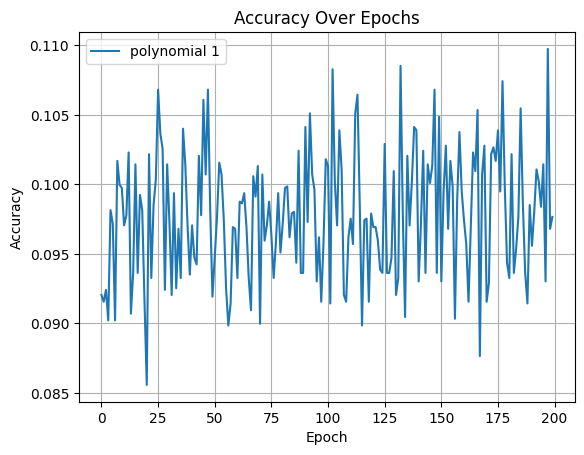

In [13]:
poly_trainer.evaluate()
poly_trainer.plot_accuracy()

In [14]:
xs1, xs2, ys, preds = [], [], [], []
for i in range(10):
    x, y = PolyDataset.generate(2, p=11)
    xs1.append(x[0].tolist())
    xs2.append(x[1].tolist())
    ys.append(y.item())
    preds.append(poly_trainer.predict(x))

df = pd.DataFrame({
    "x1": xs1,
    "x2": xs2,
    "y": ys,
    "prediction": preds
})

print(df)

       x1      x2   y  prediction
0  [8, 1]  [1, 8]   6           5
1     [2]     [9]   8           3
2     [9]     [5]   2           3
3  [2, 1]  [0, 3]   4           3
4     [7]     [2]   4           3
5     [0]     [3]   1           3
6     [8]     [8]  10           5
7     [3]     [0]   1           3
8     [6]     [3]   8           3
9     [2]     [9]   8           3


### Parity training

In [15]:
parity_trainer = poly_trainer.fork(task='parity')
parity_trainer.reset_optimizer()
parity_trainer.train(epochs=50)

Epoch 49 | Loss: 0.0350 | TokAcc(ignore PAD): 59.38% | Acc: 50.24%: 100%|██████████| 50/50 [06:45<00:00,  8.11s/it]


Token Acc (ignore PAD): 50.24% | Seq Acc (unpadded exact): 50.24%


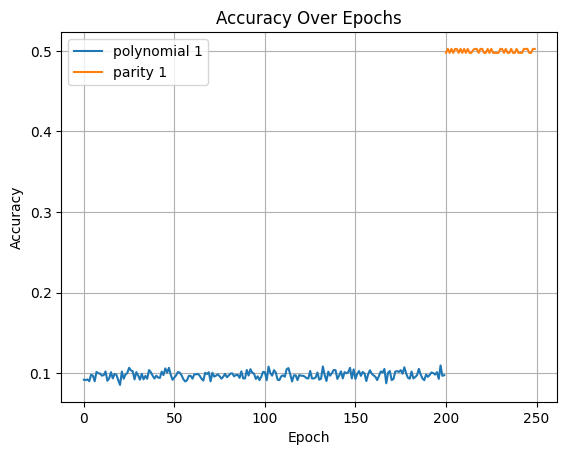

In [16]:
parity_trainer.evaluate()
parity_trainer.plot_accuracy()

In [17]:
xs, ys, preds = [], [], []
for i in range(10):
    x, y = ParityDataset.generate()
    xs.append(x)
    ys.append(y)
    preds.append(parity_trainer.predict(x))

df = pd.DataFrame({
    "bits": xs,
    "parity": ys,
    "prediction": preds
})

print(df)

                                                bits  parity  prediction
0  [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...       0           1
1  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...       0           1
2  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...       1           1
3  [0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, ...       1           1
4  [0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, ...       0           1
5  [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, ...       1           1
6  [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...       0           1
7  [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...       0           1
8  [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, ...       0           1
9  [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, ...       1           1


# Advanced Datasets to test

## Factorial training

### Direction: $ALG(x) = x!$

In [36]:
factorial_trainer = poly_trainer.fork(task='factorial')
factorial_trainer.reset_optimizer()
factorial_trainer.train(epochs=100)

Epoch 99 | Loss: 1.6229 | TokAcc(ignore PAD): 27.08% | Acc: 27.08%: 100%|██████████| 100/100 [13:28<00:00,  8.09s/it]


Token Acc (ignore PAD): 27.08% | Seq Acc (unpadded exact): 1.03%


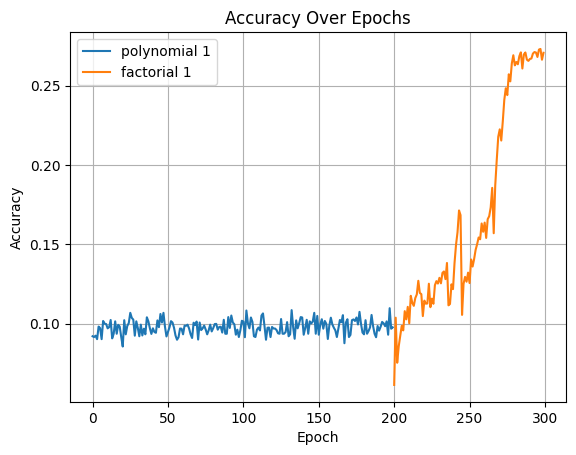

In [37]:
factorial_trainer.evaluate()
factorial_trainer.plot_accuracy()

In [38]:
xs, ys, preds = [], [], []
for i in range(10):
    x, y = FactorialDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(factorial_trainer.predict(x))

df = pd.DataFrame({
    "x": xs,
    "y": ys,
    "prediction": preds
})

print(df)

    x          y       prediction
0   3          6                2
1   4         24               14
2   5        120              120
3   6        720              120
4   7       5040             1040
5   8      40320            20320
6   9     362880           162880
7  10    3628800  369687428889835
8  11   39916800  339687428889836
9  12  479001600  319687428889837


### Direction: $ALG(x!) = x$ (Factorial inversion)

In [39]:
factorial_inv_trainer = poly_trainer.fork(task='factorial', inversion=True) 
factorial_inv_trainer.reset_optimizer()
factorial_inv_trainer.train(epochs=100)

Epoch 99 | Loss: 0.1699 | TokAcc(ignore PAD): 29.84% | Acc: 28.59%: 100%|██████████| 100/100 [13:36<00:00,  8.17s/it]


Token Acc (ignore PAD): 28.59% | Seq Acc (unpadded exact): 7.57%


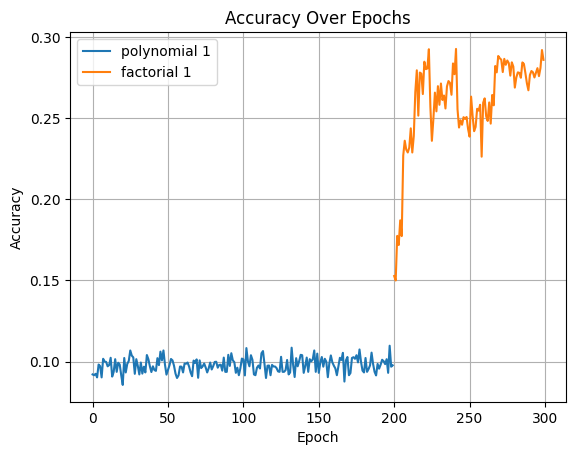

In [40]:
factorial_inv_trainer.evaluate()
factorial_inv_trainer.plot_accuracy()

In [41]:
xs, ys, preds = [], [], []
for i in range(10):
    x, y = FactorialDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(factorial_inv_trainer.predict(y))

df = pd.DataFrame({
    "y": ys,
    "x": xs,
    "prediction": preds
})

print(df)

           y   x  prediction
0          6   3           4
1         24   4          38
2        120   5          54
3        720   6          54
4       5040   7          61
5      40320   8          86
6     362880   9          17
7    3628800  10          17
8   39916800  11          13
9  479001600  12          82


## Fibonacci training

### Direction: $ALG(x) = Fibonacci(x)$

In [46]:
fibonacci_trainer = Trainer(config=config, task="fibonacci") #poly_trainer.fork(task='fibonacci')
#fibonacci_trainer.reset_optimizer()
fibonacci_trainer.train(epochs=200)

Epoch 199 | Loss: 0.1586 | TokAcc(ignore PAD): 91.23% | Acc: 91.22%: 100%|██████████| 200/200 [07:05<00:00,  2.13s/it]


Token Acc (ignore PAD): 91.22% | Seq Acc (unpadded exact): 23.67%


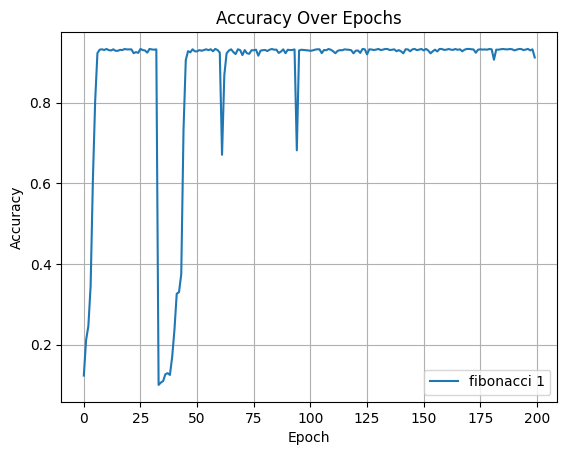

In [47]:
fibonacci_trainer.evaluate()
fibonacci_trainer.plot_accuracy()

In [48]:
xs, ys, preds = [], [], []
for i in range(30):
    x, y = FibonacciDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(fibonacci_trainer.predict(x))

df = pd.DataFrame({
    "x": xs,
    "y": ys,
    "prediction": preds
})

print(df)

     x        y       prediction
0    3        2                2
1    4        3                1
2    5        5                1
3    6        8                1
4    7       13               13
5    8       21               61
6    9       34               14
7   10       55  152248481792619
8   11       89               19
9   12      144              144
10  13      233              133
11  14      377              177
12  15      610              110
13  16      987             1877
14  17     1597             1597
15  18     2584             1584
16  19     4181             1181
17  20     6765             1765
18  21    10946            10946
19  22    17711            17711
20  23    28657            18657
21  24    46368            16368
22  25    75025            15025
23  26   121393           121393
24  27   196418           196418
25  28   317811           117811
26  29   514229           114229
27  30   832040           232040
28  31  1346269          2346269
29  32  21

### Direction: $ALG(Fibonacci(x)) = x$ (Fibonacci inversion)

In [31]:
fibonacci_inv_trainer = poly_trainer.fork(task='fibonacci', inversion=True)
fibonacci_inv_trainer.reset_optimizer()
fibonacci_inv_trainer.train(epochs=100)

Epoch 99 | Loss: 0.3152 | TokAcc(ignore PAD): 14.67% | Acc: 12.07%: 100%|██████████| 100/100 [13:35<00:00,  8.15s/it]


Token Acc (ignore PAD): 12.07% | Seq Acc (unpadded exact): 0.37%


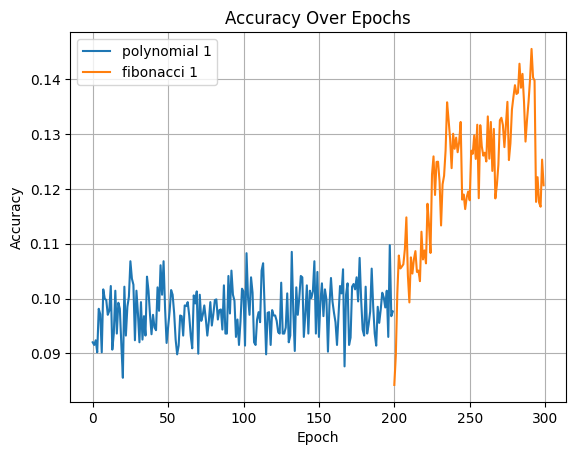

In [32]:
fibonacci_inv_trainer.evaluate()
fibonacci_inv_trainer.plot_accuracy()

In [33]:
xs, ys, preds = [], [], []
for i in range(30):
    x, y = FibonacciDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(fibonacci_inv_trainer.predict(y))

df = pd.DataFrame({
    "y": ys,
    "x": xs,
    "prediction": preds
})

print(df)

          y   x  prediction
0         2   3           8
1         3   4           8
2         5   5           6
3         8   6           8
4        13   7          80
5        21   8          85
6        34   9          81
7        55  10          67
8        89  11         800
9       144  12         811
10      233  13         801
11      377  14         874
12      610  15         855
13      987  16         599
14     1597  17         877
15     2584  18         874
16     4181  19         854
17     6765  20         870
18    10946  21         811
19    17711  22         874
20    28657  23         899
21    46368  24         899
22    75025  25         877
23   121393  26         800
24   196418  27         800
25   317811  28         855
26   514229  29         655
27   832040  30         801
28  1346269  31         809
29  2178309  32         855
